### Feature Engineering

In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import gc
import librosa

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive')

In [4]:
tracks = pd.read_csv('tracks.csv')
tracks.columns = tracks.iloc[0]
tracks = tracks.drop([0, 1])
new_cols = tracks.columns.values
new_cols[0] = 'track_id'
tracks.columns = new_cols
tracks = tracks.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
mfcc = pickle.load(open('mel-spec.pkl', 'rb'))
gc.collect()
mfcc[0]

array([[-65.062225, -47.759476, -44.176395, ..., -39.408173, -41.73693 ,
        -29.414968],
       [-65.40291 , -52.760864, -49.179825, ..., -16.405546, -16.314037,
        -17.623047],
       [-69.48193 , -56.67646 , -50.5069  , ..., -16.358839, -16.07241 ,
        -18.654762],
       ...,
       [-79.42308 , -59.74297 , -36.38287 , ..., -46.371128, -42.364655,
        -50.543457],
       [-80.      , -63.4197  , -41.733234, ..., -50.3838  , -46.90663 ,
        -58.020092],
       [-80.      , -73.82068 , -52.945995, ..., -63.188034, -56.469955,
        -67.65623 ]], dtype=float32)

In [6]:
mfcc[0].shape

(128, 646)

In [0]:
mfcc_df = pd.DataFrame(mfcc)
index_nan = np.argwhere(pd.isnull(mfcc))

In [8]:
mfcc_df = mfcc_df.dropna()
mfcc = mfcc_df.to_numpy().ravel()

max_dim = 0
for i in mfcc:
    if i.shape[1] > max_dim:
        max_dim = i.shape[1]
    else:
        pass
print(max_dim)

647


In [0]:
for i in range(len(mfcc)):
    mfcc[i] = np.append(mfcc[i], np.zeros((128, max_dim - mfcc[i].shape[1])), axis=1)
    mfcc[i] = mfcc[i][:128, :400]
    mfcc[i] = librosa.util.normalize(mfcc[i])
    
index_nan = index_nan.ravel()


In [10]:
mfcc[4].shape

(128, 400)

In [0]:
del mfcc_df

In [12]:
gc.collect()

0

In [0]:
tracks = tracks.loc[tracks['subset'] == 'small']
tracks = tracks.reset_index()
tracks = tracks.drop(index_nan)
tracks = tracks.reset_index()

In [0]:
y_train = tracks.loc[(tracks['split'] == 'training')]['genre_top']
y_val = tracks.loc[(tracks['split'] == 'validation')]['genre_top']
y_test = tracks.loc[(tracks['split'] == 'test')]['genre_top']

In [15]:
index_train = y_train.index
index_val = y_val.index
index_test = y_test.index
print(index_train)
print(index_val)
print(index_test)

Int64Index([   0,    1,    2,    3,    4,    7,    8,    9,   10,   11,
            ...
            7981, 7982, 7983, 7984, 7985, 7986, 7987, 7994, 7995, 7996],
           dtype='int64', length=6397)
Int64Index([   5,   23,   28,   36,   58,   70,  117,  122,  126,  127,
            ...
            7854, 7855, 7856, 7857, 7858, 7859, 7860, 7869, 7871, 7928],
           dtype='int64', length=800)
Int64Index([   6,   39,   40,   41,   42,   43,   44,   55,   56,   64,
            ...
            7951, 7952, 7964, 7965, 7988, 7989, 7990, 7991, 7992, 7993],
           dtype='int64', length=800)


In [16]:
len(y_train) + len(y_val) + len(y_test)

7997

In [17]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=8, dtype='int32')
y_val = tf.keras.utils.to_categorical(y_val, num_classes=8, dtype='int32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=8, dtype='int32')

gc.collect()

0

In [18]:
mfcc = np.stack(mfcc.ravel()).reshape((-1, 128, 400))
gc.collect()

0

In [19]:
mfcc.shape

(7997, 128, 400)

In [20]:
mfcc = mfcc.reshape((-1, 128, 400, 1))
mfcc.shape

(7997, 128, 400, 1)

In [21]:
mfcc[0].shape

(128, 400, 1)

In [0]:
X_train = mfcc[index_train]
X_val = mfcc[index_val]
X_test = mfcc[index_test]

In [23]:
len(X_train)

6397

In [24]:
y_train.shape

(6397, 8)

In [25]:
X_train[0]

array([[[-0.81327782],
        [-0.64696609],
        [-0.81883592],
        ...,
        [-0.40507106],
        [-0.42502928],
        [-0.45188894]],

       [[-0.81753635],
        [-0.7147166 ],
        [-0.91157748],
        ...,
        [-0.2125068 ],
        [-0.21104746],
        [-0.26406962]],

       [[-0.86852417],
        [-0.76775859],
        [-0.93617563],
        ...,
        [-0.19474493],
        [-0.19549944],
        [-0.27820868]],

       ...,

       [[-0.99278851],
        [-0.80929857],
        [-0.67437826],
        ...,
        [-0.80659521],
        [-0.74935479],
        [-0.73209325]],

       [[-1.        ],
        [-0.85910482],
        [-0.77355047],
        ...,
        [-0.84994637],
        [-0.84315453],
        [-0.79236651]],

       [[-1.        ],
        [-1.        ],
        [-0.9813857 ],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]]])

### Experiments (Multiple CNN architectures with DataGenerator in some)

Train on 5757 samples, validate on 640 samples
Epoch 1/50
5757/5757 [==============================] - 6s 1ms/step - loss: 2.5715 - categorical_accuracy: 0.1431 - val_loss: 2.4838 - val_categorical_accuracy: 0.1609

Epoch 00001: val_categorical_accuracy improved from -inf to 0.16094, saving model to best_model_cnn_mel-spec.hdf5
Epoch 2/50
5757/5757 [==============================] - 6s 1ms/step - loss: 2.3896 - categorical_accuracy: 0.2255 - val_loss: 2.3387 - val_categorical_accuracy: 0.2438

Epoch 00002: val_categorical_accuracy improved from 0.16094 to 0.24375, saving model to best_model_cnn_mel-spec.hdf5
Epoch 3/50
5757/5757 [==============================] - 6s 1ms/step - loss: 2.2137 - categorical_accuracy: 0.3021 - val_loss: 2.1556 - val_categorical_accuracy: 0.3031

Epoch 00003: val_categorical_accuracy improved from 0.24375 to 0.30312, saving model to best_model_cnn_mel-spec.hdf5
Epoch 4/50
5757/5757 [==============================] - 6s 1ms/step - loss: 2.0880 - categorical_a

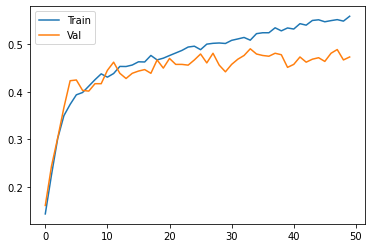

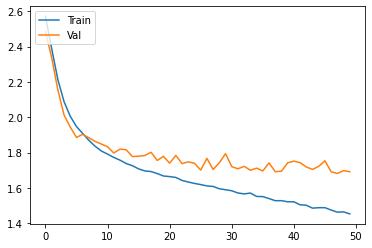

Train:
[1.5480831103602928, 0.527747392654419]
Val:
[1.6464787340164184, 0.45625001192092896]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(32, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(32, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50, verbose=1, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

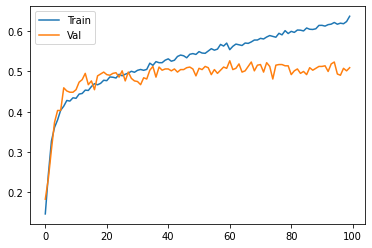

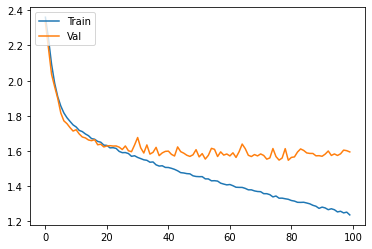

Train:
[1.396542966598754, 0.5757386088371277]
Val:
[1.5793553924560546, 0.49125000834465027]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

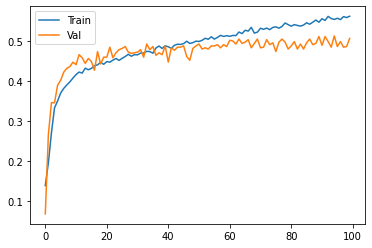

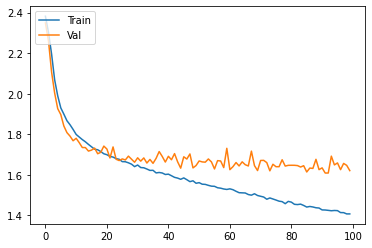

Train:
[1.406803765147109, 0.5713616013526917]
Val:
[1.6085491228103637, 0.45875000953674316]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, 400, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

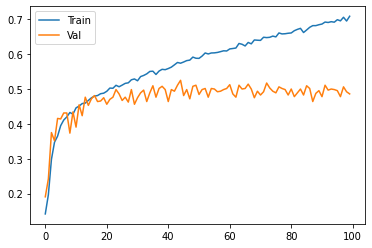

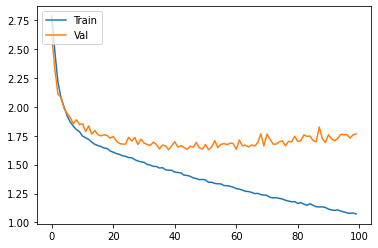

Train:
[1.384960632725248, 0.5944974422454834]
Val:
[1.641326379776001, 0.45124998688697815]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(64, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(64, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

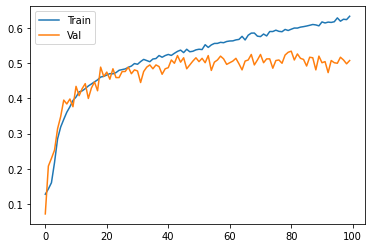

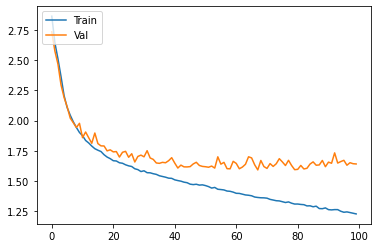

Train:
[1.2937339757110098, 0.6137251853942871]
Val:
[1.6071334314346313, 0.4712499976158142]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(64, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

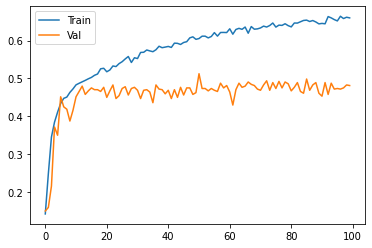

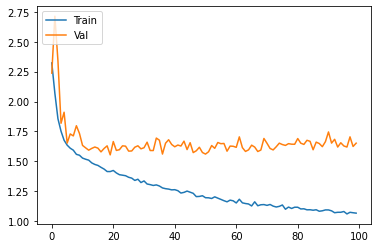

Train:
[1.1999250490515982, 0.630608081817627]
Val:
[1.6504947710037232, 0.4449999928474426]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam()
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

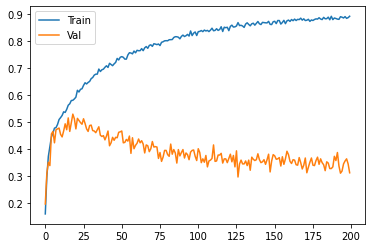

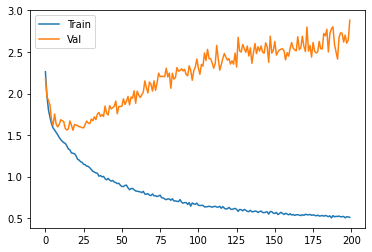

Train:
[1.3438706623496013, 0.5632327795028687]
Val:
[1.6057483673095703, 0.4975000023841858]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam()
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

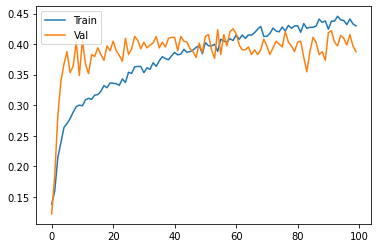

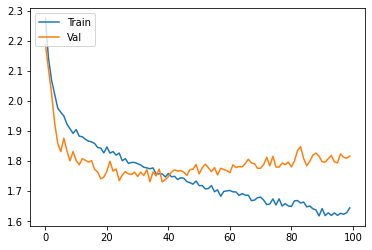

Train:
[1.589223384279487, 0.4758480489253998]
Val:
[1.82178560256958, 0.32624998688697815]


In [0]:
from keras.layers import SpatialDropout2D

activation='relu'
optimizer = keras.optimizers.Adam()
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(SpatialDropout2D(0.5))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(SpatialDropout2D(0.5))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

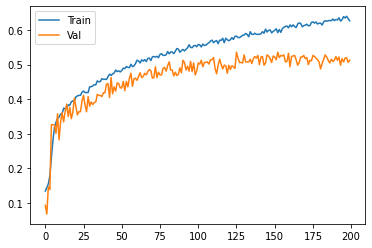

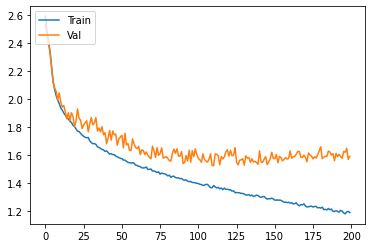

Train:
[1.3203800516760646, 0.5865249037742615]
Val:
[1.5341482257843018, 0.4650000035762787]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(32, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(32, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50, verbose=1, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

Train on 5757 samples, validate on 640 samples
Epoch 1/100
5757/5757 [==============================] - 8s 1ms/step - loss: 2.3602 - categorical_accuracy: 0.1503 - val_loss: 2.2296 - val_categorical_accuracy: 0.1703
Epoch 2/100
5757/5757 [==============================] - 8s 1ms/step - loss: 2.1452 - categorical_accuracy: 0.1994 - val_loss: 2.0417 - val_categorical_accuracy: 0.2812
Epoch 3/100
5757/5757 [==============================] - 8s 1ms/step - loss: 2.0365 - categorical_accuracy: 0.2430 - val_loss: 1.9332 - val_categorical_accuracy: 0.3594
Epoch 4/100
5757/5757 [==============================] - 8s 1ms/step - loss: 1.9772 - categorical_accuracy: 0.2644 - val_loss: 1.8280 - val_categorical_accuracy: 0.3703
Epoch 5/100
5757/5757 [==============================] - 8s 1ms/step - loss: 1.9594 - categorical_accuracy: 0.2774 - val_loss: 1.8523 - val_categorical_accuracy: 0.3938
Epoch 6/100
5757/5757 [==============================] - 8s 1ms/step - loss: 1.9377 - categorical_accuracy: 

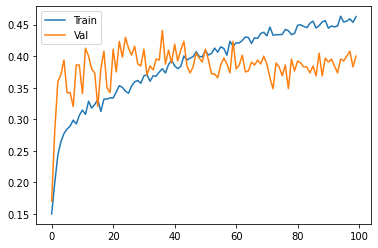

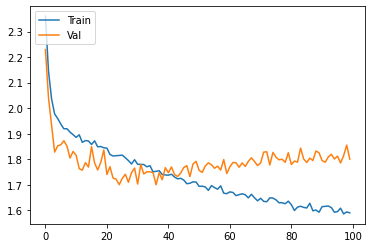

Train:
[1.6102663179813221, 0.4517742693424225]
Val:
[1.756848497390747, 0.35499998927116394]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(32, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(SpatialDropout2D(0.5))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(32, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(SpatialDropout2D(0.5))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

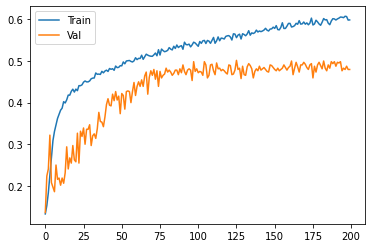

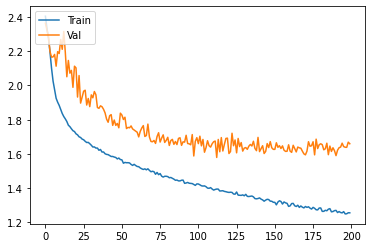

Train:
[1.4008204823306563, 0.5465061664581299]
Val:
[1.6016042804718018, 0.45249998569488525]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

Train on 5757 samples, validate on 640 samples
Epoch 1/100
5757/5757 [==============================] - 16s 3ms/step - loss: 2.8246 - categorical_accuracy: 0.2100 - val_loss: 3.7893 - val_categorical_accuracy: 0.0719
Epoch 2/100
5757/5757 [==============================] - 15s 3ms/step - loss: 2.6098 - categorical_accuracy: 0.2640 - val_loss: 5.4313 - val_categorical_accuracy: 0.0719
Epoch 3/100
5757/5757 [==============================] - 15s 3ms/step - loss: 2.4271 - categorical_accuracy: 0.3153 - val_loss: 4.8106 - val_categorical_accuracy: 0.0719
Epoch 4/100
5757/5757 [==============================] - 15s 3ms/step - loss: 2.2797 - categorical_accuracy: 0.3629 - val_loss: 2.5016 - val_categorical_accuracy: 0.3484
Epoch 5/100
5757/5757 [==============================] - 15s 3ms/step - loss: 2.1729 - categorical_accuracy: 0.3834 - val_loss: 2.1007 - val_categorical_accuracy: 0.4016
Epoch 6/100
5757/5757 [==============================] - 15s 3ms/step - loss: 2.1043 - categorical_accu

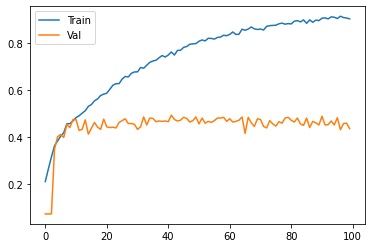

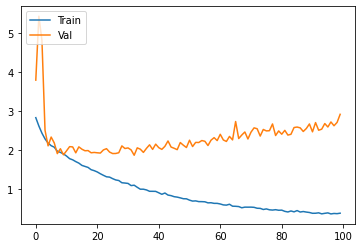

Train:
[0.7410439397648795, 0.8271064758300781]
Val:
[2.1436762237548828, 0.4437499940395355]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, input_shape=(128, max_dim, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest', validation_split=0.1)
train_batchsize = 32
val_batchsize = 16

train_generator = train_datagen.flow(X_train, y_train, batch_size=train_batchsize)
val_generator = train_datagen.flow(X_train, y_train, batch_size=val_batchsize, subset='validation')


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
#model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
#model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec-generator-dropout.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(train_generator, steps_per_epoch=len(X_train)/ train_batchsize, epochs=200, validation_data=val_generator, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec-generator-dropout.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

Epoch 1/200
200/199 [==============================] - 36s 182ms/step - loss: 2.3632 - categorical_accuracy: 0.1287 - val_loss: 2.3089 - val_categorical_accuracy: 0.1643
Epoch 2/200
200/199 [==============================] - 34s 171ms/step - loss: 2.2920 - categorical_accuracy: 0.1405 - val_loss: 2.2664 - val_categorical_accuracy: 0.0626
Epoch 3/200
200/199 [==============================] - 34s 168ms/step - loss: 2.2353 - categorical_accuracy: 0.1673 - val_loss: 2.1894 - val_categorical_accuracy: 0.1268
Epoch 4/200
200/199 [==============================] - 34s 170ms/step - loss: 2.1823 - categorical_accuracy: 0.2057 - val_loss: 2.1616 - val_categorical_accuracy: 0.2207
Epoch 5/200
200/199 [==============================] - 34s 168ms/step - loss: 2.1058 - categorical_accuracy: 0.2581 - val_loss: 2.0346 - val_categorical_accuracy: 0.3412
Epoch 6/200
200/199 [==============================] - 34s 168ms/step - loss: 2.0336 - categorical_accuracy: 0.2784 - val_loss: 2.1956 - val_categoric

Epoch 1/100
200/199 [==============================] - 64s 319ms/step - loss: 2.2516 - categorical_accuracy: 0.1296 - val_loss: 2.1997 - val_categorical_accuracy: 0.1509
Epoch 2/100
200/199 [==============================] - 62s 308ms/step - loss: 2.0898 - categorical_accuracy: 0.1896 - val_loss: 2.1265 - val_categorical_accuracy: 0.2226
Epoch 3/100
200/199 [==============================] - 62s 312ms/step - loss: 2.0027 - categorical_accuracy: 0.2421 - val_loss: 2.0722 - val_categorical_accuracy: 0.2343
Epoch 4/100
200/199 [==============================] - 61s 306ms/step - loss: 1.9279 - categorical_accuracy: 0.2640 - val_loss: 1.8874 - val_categorical_accuracy: 0.2995
Epoch 5/100
200/199 [==============================] - 62s 308ms/step - loss: 1.8875 - categorical_accuracy: 0.2854 - val_loss: 2.0242 - val_categorical_accuracy: 0.2869
Epoch 6/100
200/199 [==============================] - 61s 306ms/step - loss: 1.8614 - categorical_accuracy: 0.3012 - val_loss: 1.6921 - val_categoric

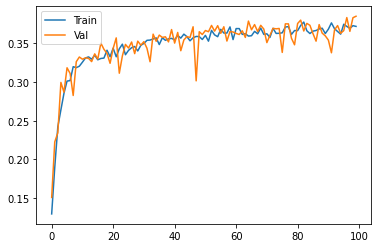

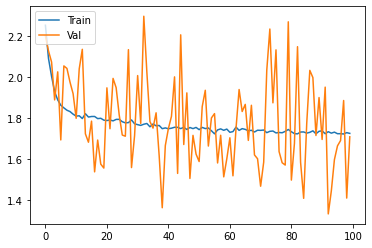

Train:
[1.8039552839879078, 0.3673596978187561]
Val:
[1.845885260105133, 0.3387500047683716]


In [0]:
activation='relu'
optimizer = keras.optimizers.Adam()
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
#model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
#model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec-generator.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(train_generator, steps_per_epoch=len(X_train)/ train_batchsize, epochs=100, validation_data=val_generator, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec-generator.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

### Try using VGG16

In [0]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(128, 400, 3))

for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0051d04c18> False
<keras.layers.convolutional.Conv2D object at 0x7efff9649160> False
<keras.layers.convolutional.Conv2D object at 0x7efff9649438> False
<keras.layers.pooling.MaxPooling2D object at 0x7efff96498d0> False
<keras.layers.convolutional.Conv2D object at 0x7efff96497f0> False
<keras.layers.convolutional.Conv2D object at 0x7efff956f7f0> False
<keras.layers.pooling.MaxPooling2D object at 0x7efff957b390> False
<keras.layers.convolutional.Conv2D object at 0x7efff957b1d0> False
<keras.layers.convolutional.Conv2D object at 0x7efff957beb8> False
<keras.layers.convolutional.Conv2D object at 0x7efff9584a58> False
<keras.layers.pooling.MaxPooling2D object at 0x7efff95904e0> False
<keras.layers.convolutional.Conv2D object at 0x7efff9590320> False
<keras.layers.convolutional.Conv2D object at 0x7efff9590fd0> False
<keras.layers.convolutional.Conv2D object at 0x7efff9574ba8> False
<keras.layers.pooling.MaxPooling2D object at 0x7efff9599668>

In [0]:
X_train_RGB = X_train.reshape((-1, 128, 400))
X_train_RGB = np.repeat(X_train_RGB[..., np.newaxis], 3, -1)
X_train_RGB.shape

(6397, 128, 400, 3)

In [0]:
X_val_RGB = X_val.reshape((-1, 128, 400))
X_val_RGB = np.repeat(X_val_RGB[..., np.newaxis], 3, -1)
X_val_RGB.shape

(800, 128, 400, 3)

Train on 5757 samples, validate on 640 samples
Epoch 1/20
5757/5757 [==============================] - 29s 5ms/step - loss: 2.1288 - categorical_accuracy: 0.1853 - val_loss: 1.7993 - val_categorical_accuracy: 0.3063

Epoch 00001: val_categorical_accuracy improved from -inf to 0.30625, saving model to retrained-model-mel-spec.hdf5
Epoch 2/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.9432 - categorical_accuracy: 0.2385 - val_loss: 1.8098 - val_categorical_accuracy: 0.4234

Epoch 00002: val_categorical_accuracy improved from 0.30625 to 0.42344, saving model to retrained-model-mel-spec.hdf5
Epoch 3/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.8704 - categorical_accuracy: 0.2838 - val_loss: 1.6551 - val_categorical_accuracy: 0.4328

Epoch 00003: val_categorical_accuracy improved from 0.42344 to 0.43281, saving model to retrained-model-mel-spec.hdf5
Epoch 4/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.8216 - catego

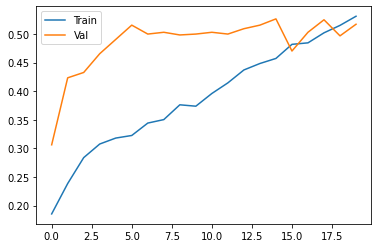

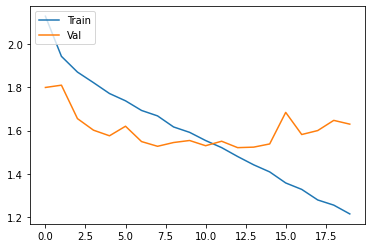

In [0]:
model = keras.Sequential()

model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['categorical_accuracy'])

mcp_save = ModelCheckpoint('retrained-model-mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1)
history = model.fit(X_train_RGB, y_train, validation_split=0.1, verbose=1, epochs=20, callbacks=[mcp_save])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = load_model('retrained-model-mel-spec.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))

In [0]:
model = load_model('retrained-model-mel-spec.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))

Train:
[1.0483733980249796, 0.6915741562843323]
Val:
[1.5134249138832092, 0.550000011920929]


Train on 5757 samples, validate on 640 samples
Epoch 1/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.9564 - categorical_accuracy: 0.2920 - val_loss: 1.8582 - val_categorical_accuracy: 0.4187

Epoch 00001: val_categorical_accuracy improved from -inf to 0.41875, saving model to retrained-model-mel-spec.hdf5
Epoch 2/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.7466 - categorical_accuracy: 0.3761 - val_loss: 1.8395 - val_categorical_accuracy: 0.4484

Epoch 00002: val_categorical_accuracy improved from 0.41875 to 0.44844, saving model to retrained-model-mel-spec.hdf5
Epoch 3/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.6573 - categorical_accuracy: 0.4120 - val_loss: 1.8719 - val_categorical_accuracy: 0.4328

Epoch 00003: val_categorical_accuracy did not improve from 0.44844
Epoch 4/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.5757 - categorical_accuracy: 0.4353 - val_loss: 1.7109 - val_cat

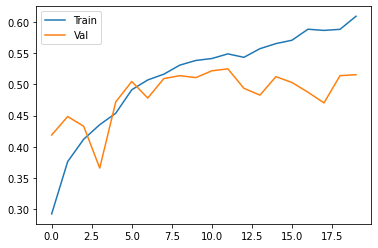

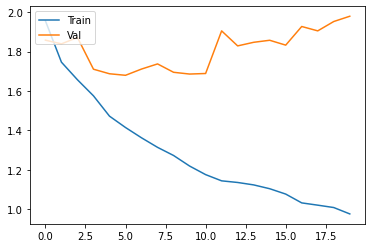

Train:
[0.7418744224895998, 0.7867750525474548]
Val:
[1.9234111356735228, 0.5475000143051147]


In [0]:
model = keras.Sequential()

model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['categorical_accuracy'])

mcp_save = ModelCheckpoint('retrained-model-mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1)
history = model.fit(X_train_RGB, y_train, validation_split=0.1, verbose=1, epochs=20, callbacks=[mcp_save])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = load_model('retrained-model-mel-spec.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))

Train on 5757 samples, validate on 640 samples
Epoch 1/20
5757/5757 [==============================] - 22s 4ms/step - loss: 14.6678 - categorical_accuracy: 0.5202 - val_loss: 5.7221 - val_categorical_accuracy: 0.5234

Epoch 00001: val_categorical_accuracy improved from -inf to 0.52344, saving model to retrained-model-mel-spec.hdf5
Epoch 2/20
5757/5757 [==============================] - 22s 4ms/step - loss: 3.4452 - categorical_accuracy: 0.6608 - val_loss: 3.1046 - val_categorical_accuracy: 0.5250

Epoch 00002: val_categorical_accuracy improved from 0.52344 to 0.52500, saving model to retrained-model-mel-spec.hdf5
Epoch 3/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.9690 - categorical_accuracy: 0.6719 - val_loss: 2.4459 - val_categorical_accuracy: 0.5203

Epoch 00003: val_categorical_accuracy did not improve from 0.52500
Epoch 4/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.5714 - categorical_accuracy: 0.6830 - val_loss: 2.2864 - val_ca

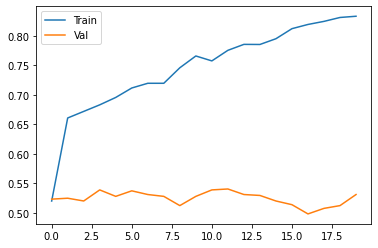

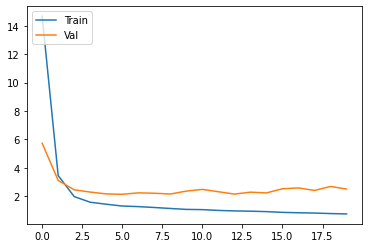

Train:
[0.8022680784997408, 0.9119899868965149]
Val:
[2.286885743141174, 0.5287500023841858]


In [0]:
model = keras.Sequential()

model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l1()))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['categorical_accuracy'])

mcp_save = ModelCheckpoint('retrained-model-mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1)
history = model.fit(X_train_RGB, y_train, validation_split=0.1, verbose=1, epochs=20, callbacks=[mcp_save])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = load_model('retrained-model-mel-spec.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))

Train on 5757 samples, validate on 640 samples
Epoch 1/20
5757/5757 [==============================] - 22s 4ms/step - loss: 12.7724 - categorical_accuracy: 0.5776 - val_loss: 4.6243 - val_categorical_accuracy: 0.5172

Epoch 00001: val_categorical_accuracy improved from -inf to 0.51719, saving model to retrained-model-mel-spec.hdf5
Epoch 2/20
5757/5757 [==============================] - 22s 4ms/step - loss: 2.5240 - categorical_accuracy: 0.7705 - val_loss: 3.3559 - val_categorical_accuracy: 0.5188

Epoch 00002: val_categorical_accuracy improved from 0.51719 to 0.51875, saving model to retrained-model-mel-spec.hdf5
Epoch 3/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.5719 - categorical_accuracy: 0.8011 - val_loss: 2.8393 - val_categorical_accuracy: 0.4953

Epoch 00003: val_categorical_accuracy did not improve from 0.51875
Epoch 4/20
5757/5757 [==============================] - 22s 4ms/step - loss: 1.1916 - categorical_accuracy: 0.8147 - val_loss: 2.7086 - val_ca

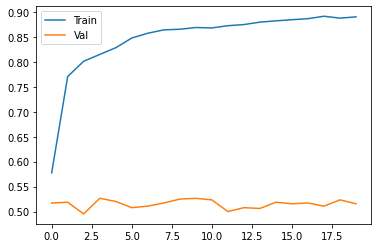

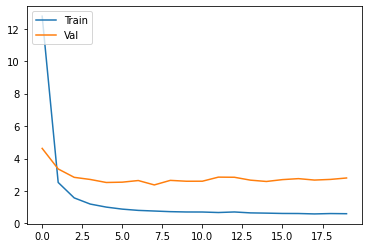

Train:
[0.8997822296103221, 0.9357511401176453]
Val:
[2.936539263725281, 0.5099999904632568]


In [0]:
model = keras.Sequential()

model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l1_l2()))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['categorical_accuracy'])

mcp_save = ModelCheckpoint('retrained-model-mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1)
history = model.fit(X_train_RGB, y_train, validation_split=0.1, verbose=1, epochs=20, callbacks=[mcp_save])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = load_model('retrained-model-mel-spec.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))

### Using VGG with best parameters and ImageDataGenerator

In [26]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(128, 400, 3))

for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

58892288/58889256 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f0f203c4860> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec75123c8> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec7512630> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0ec7512b00> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec7512a58> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec7428ef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0ec7438550> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec7438390> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec7438f98> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec7437c50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0ec7447908> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec7447b00> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec7426a90> False
<keras.layers.convolutional.Conv2D object at 0x7f0ec7426e48> F

In [27]:
X_train_RGB = X_train.reshape((-1, 128, 400))
X_train_RGB = np.repeat(X_train_RGB[..., np.newaxis], 3, -1)
X_train_RGB.shape

(6397, 128, 400, 3)

In [28]:
X_val_RGB = X_val.reshape((-1, 128, 400))
X_val_RGB = np.repeat(X_val_RGB[..., np.newaxis], 3, -1)
X_val_RGB.shape

(800, 128, 400, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_batchsize = 32
val_batchsize = 16
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_RGB, y_train, batch_size=train_batchsize)
#val_generator = train_datagen.flow(X_train_RGB, y_train, batch_size=val_batchsize, subset='validation')


Epoch 1/50
200/199 [==============================] - 66s 332ms/step - loss: 2.1880 - categorical_accuracy: 0.1330 - val_loss: 2.0838 - val_categorical_accuracy: 0.1775
Epoch 2/50
200/199 [==============================] - 62s 311ms/step - loss: 2.0670 - categorical_accuracy: 0.1569 - val_loss: 2.0088 - val_categorical_accuracy: 0.2750
Epoch 3/50
200/199 [==============================] - 61s 304ms/step - loss: 2.0270 - categorical_accuracy: 0.2067 - val_loss: 2.0104 - val_categorical_accuracy: 0.2400
Epoch 4/50
200/199 [==============================] - 61s 303ms/step - loss: 1.9800 - categorical_accuracy: 0.2376 - val_loss: 1.8380 - val_categorical_accuracy: 0.3237
Epoch 5/50
200/199 [==============================] - 61s 306ms/step - loss: 1.9264 - categorical_accuracy: 0.2576 - val_loss: 1.8716 - val_categorical_accuracy: 0.3562
Epoch 6/50
200/199 [==============================] - 61s 304ms/step - loss: 1.8920 - categorical_accuracy: 0.2786 - val_loss: 1.7955 - val_categorical_acc

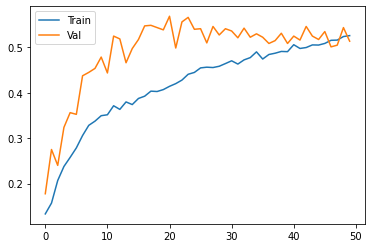

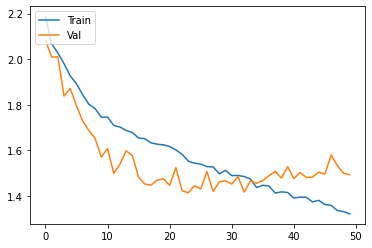

Train:
[1.366896276755763, 0.5612005591392517]
Val:
[1.4467696738243103, 0.5687500238418579]


In [0]:
model = keras.Sequential()

model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['categorical_accuracy'])

mcp_save = ModelCheckpoint('retrained-model-mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(train_generator, steps_per_epoch=len(X_train)/ train_batchsize, epochs=50, validation_data=(X_val_RGB, y_val), callbacks=[mcp_save])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = load_model('retrained-model-mel-spec.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))

Epoch 1/50
200/199 [==============================] - 80s 399ms/step - loss: 2.2253 - categorical_accuracy: 0.1301 - val_loss: 2.1532 - val_categorical_accuracy: 0.1363
Epoch 2/50
200/199 [==============================] - 73s 367ms/step - loss: 2.1418 - categorical_accuracy: 0.1280 - val_loss: 2.1066 - val_categorical_accuracy: 0.1800
Epoch 3/50
200/199 [==============================] - 73s 367ms/step - loss: 2.1016 - categorical_accuracy: 0.1602 - val_loss: 2.0891 - val_categorical_accuracy: 0.1975
Epoch 4/50
200/199 [==============================] - 74s 368ms/step - loss: 2.0690 - categorical_accuracy: 0.1946 - val_loss: 1.9970 - val_categorical_accuracy: 0.2850
Epoch 5/50
200/199 [==============================] - 73s 367ms/step - loss: 2.0099 - categorical_accuracy: 0.2425 - val_loss: 1.9566 - val_categorical_accuracy: 0.2775
Epoch 6/50
200/199 [==============================] - 73s 365ms/step - loss: 1.9742 - categorical_accuracy: 0.2661 - val_loss: 1.9272 - val_categorical_acc

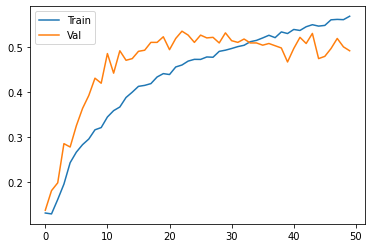

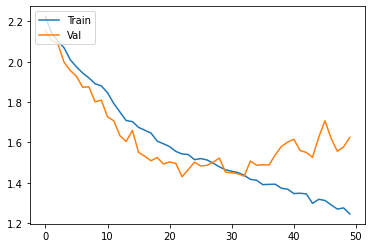

Train:
[1.341331589421351, 0.5479130744934082]
Val:
[1.4297495007514953, 0.5362499952316284]


In [30]:
model = keras.Sequential()

model.add(vgg_conv)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['categorical_accuracy'])

mcp_save = ModelCheckpoint('retrained-model-mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(train_generator, steps_per_epoch=len(X_train)/ train_batchsize, epochs=50, validation_data=(X_val_RGB, y_val), callbacks=[mcp_save])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = load_model('retrained-model-mel-spec.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))